<a href="https://colab.research.google.com/github/SayedUddinRayhan/Machine-Learning-Projects/blob/master/Abstract_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An NLP model to make reading medical abstracts easier.

In [2]:
# GPU access confirmation
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f4a8192e-5fc6-7340-2855-144e012de89e)


##Get Data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

##Preprocess data

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

### Dataset Format
[
    {
        
        'line_number': 0,     
        'target': 'BACKGROUND',
        'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
        'total_lines': 11
    },

    # Next instance of data
    {
        ......
    }
]

In [10]:
# Let's write a function which turns each of our datasets into the above format.
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 470 ms, sys: 112 ms, total: 582 ms
Wall time: 584 ms


In [12]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [13]:
# Trun our data it into a DataFrame to better visualize it
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

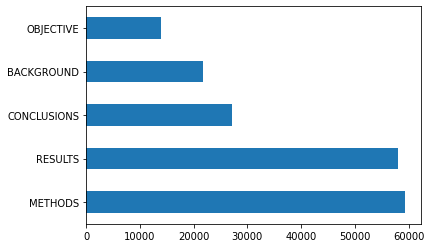

In [26]:
# Visualize the distribution in training data (according to no. of samples per target)

train_df['target'].value_counts().plot(kind='barh')

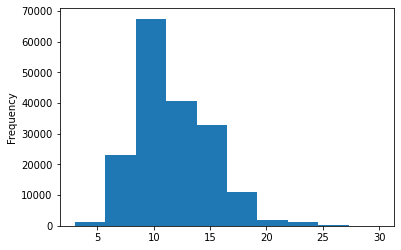

In [15]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels

In [18]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [143]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling experiments

### Model 0: TF-IDF Multinomial Naive Bayes Classifier (Getting a baseline)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Model Evaluation

In [27]:
# Cross validation
from sklearn.model_selection import cross_val_predict

# Make predictions using the Naive Bayes Classifier
baseline_preds = model_0.predict(val_sentences)

# Make predictions using the K-fold cross validation
y_val_preds = cross_val_predict(model_0, val_sentences, val_labels_encoded, cv=3)

print(baseline_preds)
print(y_val_preds)

[4 1 3 ... 4 4 1]
[4 1 2 ... 4 4 0]


In [28]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
'''
An optimal confusion matrix would be one with non-zero integers in the diagonal (top left to bottom right)

1 0 0 0 0
0 1 0 0 0
0 0 1 0 0
0 0 0 1 0
0 0 0 0 1
'''

confusion_matrix(val_labels_encoded, baseline_preds)

array([[1683,  794,  694,   97,  181],
       [ 244, 2687,  432,    5, 1214],
       [ 116,   75, 8670,    7, 1096],
       [ 505,  422,  978,  325,  146],
       [  20,  181, 1196,    1, 8443]])

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculate_results(y_true, y_pred):
    '''
    Calculates model accuracy, precision, recall, f1 score of a binary classification model
    
    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array
        
    Returns:
        A dictionary of metrics
    '''
    
    # Calculate the model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    
    # Calculate the model precision, recall and f1 score
    model_precision = precision_score(y_true, y_pred, average='weighted')
    model_recall = recall_score(y_true, y_pred, average='weighted')
    model_f1 = f1_score(y_true, y_pred, average='weighted')
    
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

In [36]:
# Metrics
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing data for deep sequence models

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [42]:
# If we want to create embedding layers, we need the sentences to be of equal lengths
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

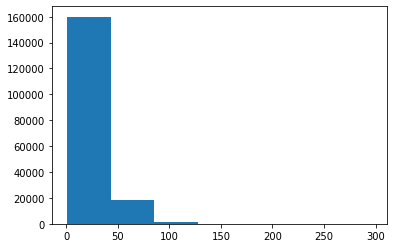

In [43]:
# Visualize the distribution of sentence lengths to get a clearer picture
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's percentile to find the value which covers 95% of the sentence lengths.

In [45]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [46]:
# Maximum sentence length in the training set
max(sent_lens)

296

Since 95% of sentences are below 55 tokens in length, it wouldn't make sense to set 296 as the maximum length because then, majority of the data we pass to our model would be zeros (from padding)

###Convert sentences into numbers

Method 1: Text Vectorizer

Method 2: Tokenizer

### Creating a Text vectorizer

Using the information from above, the appropriate value for max_length is 55.

In [47]:
# Vocabulary size for the 20k dataset is 68000 according to the paper
max_tokens = 68000
max_length = 55

In [48]:
# Two methods, TextVectorization & Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=max_tokens, # Number of words in vocabulary 
    output_sequence_length = max_length # Desired output of vectorized sentences
)

In [49]:
# Adapt textvectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [50]:
# Testing out the text vectorizer
import random

random_sentence = random.choice(train_sentences)
print(f"Actual Text:\n{random_sentence}\n")
print(f"Length of text: {len(random_sentence.split())}\n")
print(f"Vectorized sentence:\n{text_vectorizer([random_sentence])}")

Actual Text:
of the @ patients screened , @ patients were randomized to receive quetiapine-xr ( n = @ ) or placebo ( n = @ ) .

Length of text: 26

Vectorized sentence:
[[    4     2    12  1617    12     9    29     6   175 18071    40    16
     48    40     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


### Obtain vocab list

Obtain vocabulary of the dataset, using the .get_vocabulary() method of the text vectorizer

In [51]:
rct_20k_vocab = text_vectorizer.get_vocabulary()

# Get the size of the vocabulary
print(f"Number of words in vocabulary: {len(rct_20k_vocab)}\n")
print(f"Most commmon words in vocabulary: {rct_20k_vocab[:5]}\n")
print(f"Least common words in vocabulary: {rct_20k_vocab[-5:]}")

Number of words in vocabulary: 64841

Most commmon words in vocabulary: ['', '[UNK]', 'the', 'and', 'of']

Least common words in vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [52]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

Earlier, we mapped words to numbers, but this doesn't capture relationships between the numbers. To do this, we can use embeddings

In [53]:
embedding_dim = 128

# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show an instance of embedding
print(f"Sentence before embedding:\n{random_sentence}\n")

vectorized_sentence = text_vectorizer([random_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")

embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Shape of embedded sentence: {embedded_sentence.shape}\n")

Sentence before embedding:
of the @ patients screened , @ patients were randomized to receive quetiapine-xr ( n = @ ) or placebo ( n = @ ) .

Sentence after vectorization (before embedding):
[[    4     2    12  1617    12     9    29     6   175 18071    40    16
     48    40     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.02372975  0.0084242  -0.02638283 ...  0.02134626 -0.01658466
    0.00556971]
  [ 0.0434357   0.01702014  0.0062613  ...  0.03309682  0.03248078
    0.03113147]
  [ 0.04312578 -0.02185272  0.01690996 ...  0.02313675  0.02069087
    0.02027359]
  ...
  [ 0.03530988 -0.03526733  0.01909014 ... -0.03384896  0.04843929
    0.02560375]
  [ 0.03530988 -0.03526733  0.01909014 ... -0.03384896  0.04843929
    0.02560375]
  [ 0.03530988 -0.0

### Create datasets (for quick runtime)

In [55]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [56]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [57]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [58]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [59]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9146 - accuracy: 0.6366 - val_loss: 0.6926 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6646 - accuracy: 0.7529 - val_loss: 0.6352 - val_accuracy: 0.7676
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6246 - accuracy: 0.7719 - val_loss: 0.6025 - val_accuracy: 0.7866


### Model Evaluation

In [60]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.6055 - accuracy: 0.7845


[0.6054808497428894, 0.7845227122306824]

In [61]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.2128626e-01, 1.9362918e-01, 8.1117831e-02, 2.7016538e-01,
        3.3801269e-02],
       [4.1286328e-01, 3.2235956e-01, 1.1393102e-02, 2.4664983e-01,
        6.7341602e-03],
       [1.4513664e-01, 1.3405476e-02, 2.0300501e-03, 8.3939421e-01,
        3.3478769e-05],
       ...,
       [5.7316029e-06, 8.7564706e-04, 8.6990063e-04, 2.0454245e-06,
        9.9824667e-01],
       [5.1038459e-02, 4.8642939e-01, 7.3387675e-02, 5.5869091e-02,
        3.3327541e-01],
       [2.0760077e-01, 5.8299255e-01, 5.5128735e-02, 7.6061346e-02,
        7.8216583e-02]], dtype=float32)

In [62]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [63]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.45227062094531,
 'f1': 0.7821570493274542,
 'precision': 0.7814502915197608,
 'recall': 0.7845227062094532}

In [64]:
all_model_results = pd.DataFrame({
    "Multinomial Naive Bayes Classifier": baseline_results,
    "Conv1D w/ token embeddings": model_1_results,
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
Multinomial Naive Bayes Classifier,72.183238,0.718647,0.721832,0.698925
Conv1D w/ token embeddings,78.452271,0.781450,0.784523,0.782157


##Model 2: Feature extraction with pretrained token embeddings

### Model Training

Use a pretrained embedding layer from TFHub

In [66]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [67]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
academic research laboratory .

Sentence after embedding:
[ 0.00624977 -0.00479187 -0.01969762  0.0503995  -0.04979035 -0.0418777
  0.01331447 -0.01315169  0.03191689 -0.07023338  0.06876129  0.01356821
  0.07933378 -0.00529301  0.06537686  0.00549653 -0.0638066   0.05318452
  0.03171282 -0.08373211 -0.03912031  0.01751401 -0.03579599  0.07221813
  0.0091739   0.06835698  0.06833655 -0.0203264  -0.03937605  0.05347857] (truncated output)...

Length of sentence embedding:
512


### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [68]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [70]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 24s 30ms/step - loss: 0.9210 - accuracy: 0.6475 - val_loss: 0.7964 - val_accuracy: 0.6922
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7698 - accuracy: 0.7017 - val_loss: 0.7547 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7531 - accuracy: 0.7121 - val_loss: 0.7373 - val_accuracy: 0.7184


### Model Evaluation

In [71]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.7410 - accuracy: 0.7135


[0.740982711315155, 0.7135244011878967]

In [72]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.2134067e-01, 3.8648999e-01, 2.9542511e-03, 1.7844611e-01,
        1.0769052e-02],
       [3.3621067e-01, 5.0908905e-01, 4.0678908e-03, 1.4641057e-01,
        4.2217746e-03],
       [2.3022468e-01, 1.3775758e-01, 1.9070711e-02, 5.7846940e-01,
        3.4477592e-02],
       ...,
       [1.6321377e-03, 5.6409226e-03, 5.5450253e-02, 6.9701817e-04,
        9.3657970e-01],
       [3.9809137e-03, 5.2587617e-02, 2.1441551e-01, 1.4607593e-03,
        7.2755522e-01],
       [1.6125245e-01, 2.7001390e-01, 4.9673629e-01, 7.1336380e-03,
        6.4863734e-02]], dtype=float32)

In [73]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [74]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.35244273798492,
 'f1': 0.7105648943325793,
 'precision': 0.7144028532683419,
 'recall': 0.7135244273798491}

### Compare the model results so far

In [75]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embedding,78.452271,0.781450,0.784523,0.782157
pretrained token embedding layer,71.352443,0.714403,0.713524,0.710565


## Model 3: Conv1D with character embeddings

In [76]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'a c a d e m i c   r e s e a r c h   l a b o r a t o r y   .'

In [77]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [78]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

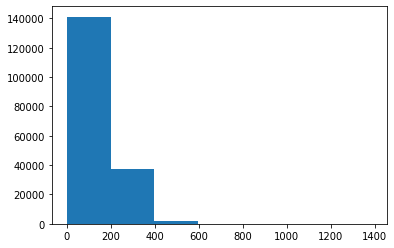

In [79]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [80]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [81]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [82]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [83]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [84]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i n   t h e   t r o p h i c   b r e a s t   m i l k   f e e d s   g r o u p   (   n   =   @   )   ,   t h e   m e a n   u r i n e   l / m   r a t i o   w a s   @   a t   p r e o p   ,   @   a t   p o s t o p   d a y   @   ,   a n d   @   a t   p o s t o p   d a y   @   .

Length of chars: 101

Vectorized chars:
[[ 4  6  3 13  2  3  8  7 14 13  4 11 22  8  2  5  9  3 15  4 12 23 17  2
   2 10  9 18  8  7 16 14  6  3 13  2 15  2  5  6 16  8  4  6  2 12 15  8
   5  3  4  7 20  5  9  5  3 14  8  2  7 14  5  3 14  7  9  3  7 14 10  5
  19  5  6 10  5  3 14  7  9  3  7 14 10  5 19  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0 

### Create character-level embeddings

In [85]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i n   t h e   t r o p h i c   b r e a s t   m i l k   f e e d s   g r o u p   (   n   =   @   )   ,   t h e   m e a n   u r i n e   l / m   r a t i o   w a s   @   a t   p r e o p   ,   @   a t   p o s t o p   d a y   @   ,   a n d   @   a t   p o s t o p   d a y   @   .

Embedded chars (after vectorization and embedding):
[[[-0.0272164   0.00337332 -0.03645282 ...  0.03524527 -0.0144841
    0.04823974]
  [-0.02487171  0.02753625  0.04900866 ...  0.03385988  0.00399897
   -0.02405301]
  [-0.00591077 -0.003603   -0.03166564 ...  0.04379672  0.02987862
   -0.01097182]
  ...
  [-0.03773008  0.03684555  0.0236561  ...  0.00766387  0.04475434
    0.01668957]
  [-0.03773008  0.03684555  0.0236561  ...  0.00766387  0.04475434
    0.01668957]
  [-0.03773008  0.03684555  0.0236561  ...  0.00766387  0.04475434
    0.01668957]]]

Character embedding shape: (1, 290, 25)


### Model Training

In [86]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [87]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [88]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [89]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 1.2619 - accuracy: 0.4848 - val_loss: 1.0664 - val_accuracy: 0.5672
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0262 - accuracy: 0.5854 - val_loss: 0.9661 - val_accuracy: 0.6077
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9355 - accuracy: 0.6310 - val_loss: 0.8891 - val_accuracy: 0.6572


### Model Evaluation

In [90]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.9007 - accuracy: 0.6499


[0.900663435459137, 0.6499404311180115]

In [91]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.1012588 , 0.5889995 , 0.05066592, 0.24398765, 0.01508807],
       [0.07044704, 0.6672982 , 0.01666579, 0.19398524, 0.05160367],
       [0.04549674, 0.10616896, 0.5845258 , 0.13701127, 0.12679715],
       ...,
       [0.01693919, 0.02150666, 0.1870908 , 0.02568878, 0.7487745 ],
       [0.01043328, 0.03110577, 0.49505922, 0.01391279, 0.4494889 ],
       [0.5049378 , 0.28497666, 0.07604287, 0.12561937, 0.00842333]],
      dtype=float32)

In [92]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 2, 0])>

In [93]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 64.99404210247583,
 'f1': 0.6414490122840084,
 'precision': 0.6444009204927803,
 'recall': 0.6499404210247584}

In [94]:
# Results of the models built so far
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results,
    "Conv1D with character-level embedding":model_3_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embedding,78.452271,0.781450,0.784523,0.782157
pretrained token embedding layer,71.352443,0.714403,0.713524,0.710565
Conv1D with character-level embedding,64.994042,0.644401,0.649940,0.641449


## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [95]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [96]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

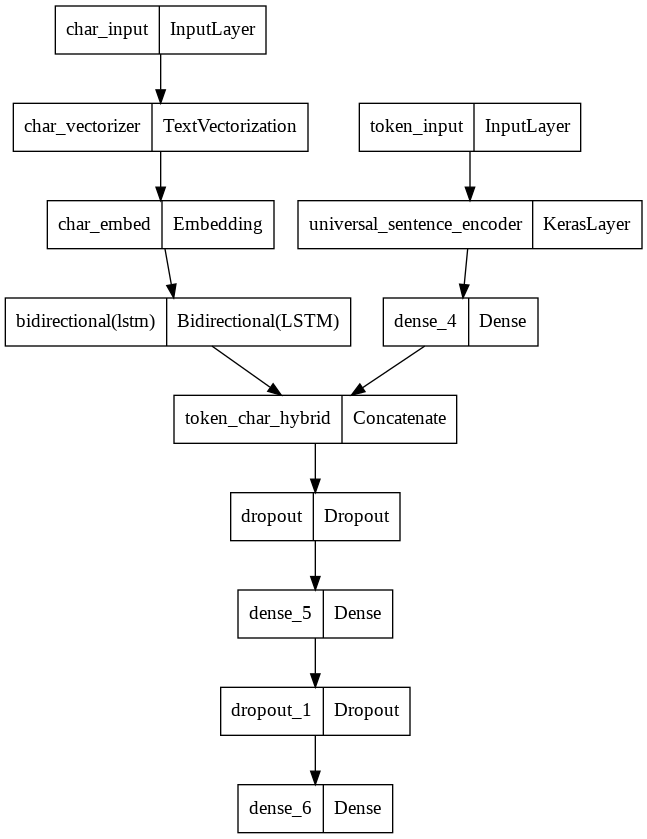

In [97]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [98]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

### Combining token and character data into a tf.data dataset

In [100]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [101]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [102]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 30s 40ms/step - loss: 0.9716 - accuracy: 0.6085 - val_loss: 0.7837 - val_accuracy: 0.6961
Epoch 2/3
562/562 [==============================] - 22s 38ms/step - loss: 0.7943 - accuracy: 0.6926 - val_loss: 0.7148 - val_accuracy: 0.7327
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.7663 - accuracy: 0.7081 - val_loss: 0.6934 - val_accuracy: 0.7367


In [103]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 26s 28ms/step - loss: 0.6955 - accuracy: 0.7334


[0.6955342292785645, 0.7333509922027588]

In [104]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.5629234e-01, 4.3441722e-01, 3.3682087e-03, 1.9579963e-01,
        1.0122623e-02],
       [3.0665180e-01, 4.8476040e-01, 3.7858994e-03, 2.0220186e-01,
        2.5999816e-03],
       [2.6949936e-01, 2.4418350e-01, 3.7535619e-02, 4.0220276e-01,
        4.6578743e-02],
       ...,
       [4.6090918e-04, 5.4779542e-03, 5.2537661e-02, 1.6651064e-04,
        9.4135696e-01],
       [5.4274118e-03, 5.8108445e-02, 1.3354832e-01, 2.6950166e-03,
        8.0022085e-01],
       [3.5684085e-01, 2.8505290e-01, 2.5624105e-01, 4.2226050e-02,
        5.9639234e-02]], dtype=float32)

In [105]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [106]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.33509863630346,
 'f1': 0.7306508152766311,
 'precision': 0.731900334490656,
 'recall': 0.7333509863630345}

In [107]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results,
    "Conv1D with character-level embedding":model_3_results,
    "Token & Char Hybrid Embedding w/ Bi-LSTM": model_4_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embedding,78.452271,0.781450,0.784523,0.782157
pretrained token embedding layer,71.352443,0.714403,0.713524,0.710565
Conv1D with character-level embedding,64.994042,0.644401,0.649940,0.641449
Token & Char Hybrid Embedding w/ Bi-LSTM,73.335099,0.731900,0.733351,0.730651


## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [108]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [109]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

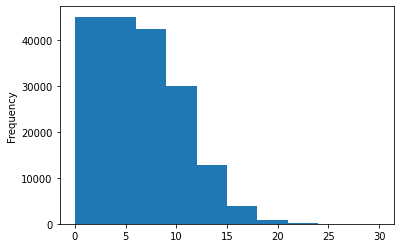

In [110]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [111]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [112]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [113]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

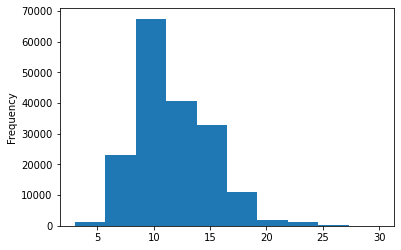

In [114]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [115]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [116]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

In [117]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [118]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

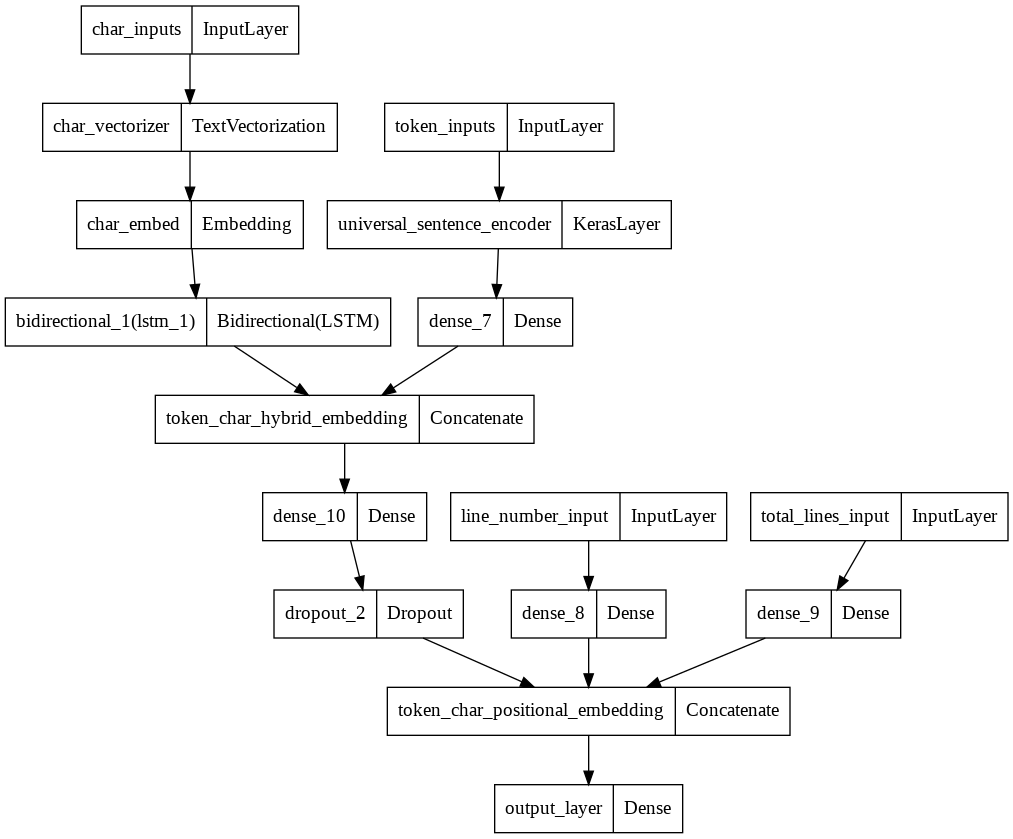

In [119]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)


In [120]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2be7f7be90> True
<keras.engine.input_layer.InputLayer object at 0x7f2be74ba5d0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f2ae913d850> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f2bd4152290> False
<keras.layers.embeddings.Embedding object at 0x7f2bcbfc3350> True
<keras.layers.core.dense.Dense object at 0x7f2bcbbdc210> True
<keras.layers.wrappers.Bidirectional object at 0x7f2bcbdfdc50> True
<keras.layers.merge.Concatenate object at 0x7f2be7383e90> True
<keras.engine.input_layer.InputLayer object at 0x7f2be7412390> True
<keras.engine.input_layer.InputLayer object at 0x7f2be74a3dd0> True
<keras.layers.core.dense.Dense object at 0x7f2be7282890> True
<keras.layers.core.dense.Dense object at 0x7f2be745bd10> True
<keras.layers.core.dense.Dense object at 0x7f2be745cf50> True
<keras.layers.core.dropout.Dropout object at 0x7f2bcbf85310> True
<keras.layers.merge.Concatenate object at 0x7f2be7

In [121]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets and fit tribrid model

In [122]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [123]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 56ms/step - loss: 1.0991 - accuracy: 0.7211 - val_loss: 0.9854 - val_accuracy: 0.7985
Epoch 2/3
562/562 [==============================] - 30s 54ms/step - loss: 0.9699 - accuracy: 0.8132 - val_loss: 0.9514 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9525 - accuracy: 0.8243 - val_loss: 0.9370 - val_accuracy: 0.8308


In [124]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 29s 30ms/step


array([[0.5294922 , 0.10891747, 0.01481327, 0.32845795, 0.01831907],
       [0.5358114 , 0.09362897, 0.04588962, 0.31243652, 0.01223346],
       [0.2951981 , 0.0912696 , 0.1451462 , 0.40862453, 0.05976156],
       ...,
       [0.0451495 , 0.100099  , 0.04621805, 0.03636252, 0.77217096],
       [0.03239362, 0.275249  , 0.07753012, 0.02894646, 0.5858808 ],
       [0.24818753, 0.5051472 , 0.12078506, 0.05293203, 0.07294813]],
      dtype=float32)

In [125]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [126]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.30795710313782,
 'f1': 0.8319706068648379,
 'precision': 0.8320283148728147,
 'recall': 0.8330795710313783}

### Compare model results

In [127]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results,
    "Conv1D with character-level embedding":model_3_results,
    "Token & Char Hybrid Embedding w/ Bi-LSTM": model_4_results,
    "Token & Char & Positional Embedding w/ Bi-LSTM": model_5_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embedding,78.452271,0.781450,0.784523,0.782157
pretrained token embedding layer,71.352443,0.714403,0.713524,0.710565
Conv1D with character-level embedding,64.994042,0.644401,0.649940,0.641449
Token & Char Hybrid Embedding w/ Bi-LSTM,73.335099,0.731900,0.733351,0.730651
Token & Char & Positional Embedding w/ Bi-LSTM,83.307957,0.832028,0.833080,0.831971


The tribrid model performs the best by a fair margin

In [128]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

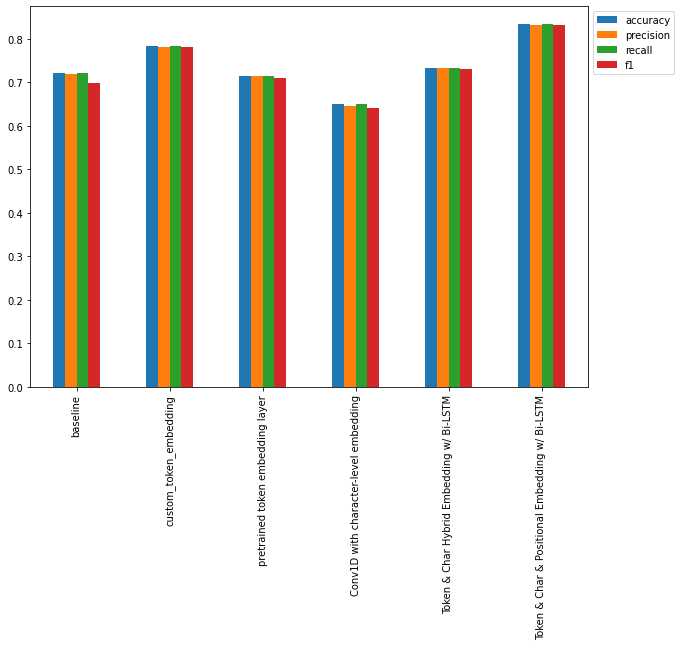

In [129]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

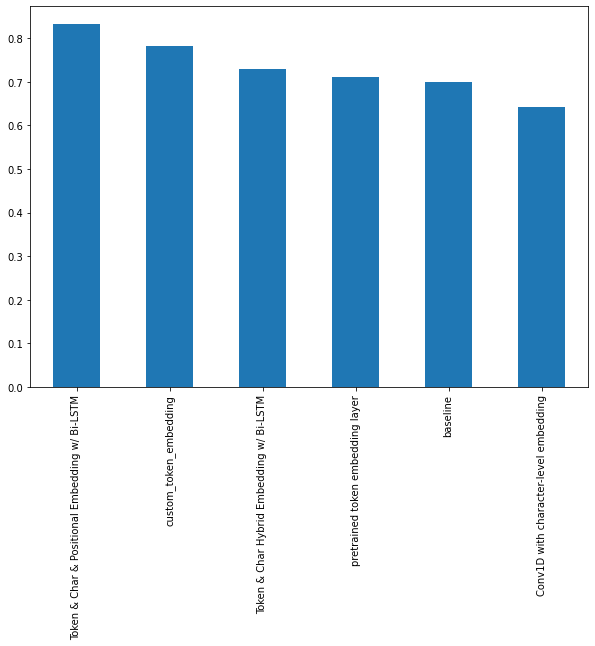

In [130]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

### Save and load best performing model

In [131]:
# Save best performing model to SavedModel format (default)
model_5.save("abstractClassifier_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: abstractClassifier_tribrid_model/assets


INFO:tensorflow:Assets written to: abstractClassifier_tribrid_model/assets


### Model 5 Evaluation on the Test dataset

In [140]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [141]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                 verbose=1)

test_preds = tf.argmax(test_pred_probs, axis=1) # returns index in that sample's probability array
test_preds[:10]

942/942 [==============================] - 25s 27ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [145]:
test_results = calculate_results(y_true=test_label_encoded,
                                y_pred=test_preds)
test_results

{'accuracy': 82.76754604280737,
 'f1': 0.8264948257058201,
 'precision': 0.8261284860650191,
 'recall': 0.8276754604280737}